# Research for TA and Testing

In [2]:
import pandas as pd
import ccxt
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import tensorflow as tf
import joblib


# Data Collection

,date,open,high,low,close,volume,datetime
0,1577854800000,7198.52,7198.52,7198.52,7198.52,0.060000,2020-01-01 05:00:00
1,1577855100000,7200.59,7200.59,7200.59,7200.59,0.105825,2020-01-01 05:05:00
2,1577855400000,7200.00,7200.00,7200.00,7200.00,0.041522,2020-01-01 05:10:00
3,1577855700000,7200.00,7200.00,7197.94,7198.20,0.176478,2020-01-01 05:15:00
4,1577856000000,7198.20,7198.20,7198.20,7198.20,0.000000,2020-01-01 05:20:00
...,...,...,...,...,...,...,...
995,1578153300000,7309.43,7309.43,7309.43,7309.43,0.000000,2020-01-04 15:55:00
996,1578153600000,7310.24,7310.24,7295.39,7295.39,0.600828,2020-01-04 16:00:00
997,1578153900000,7302.63,7302.63,7302.63,7302.63,0.001388,2020-01-04 16:05:00
998,1578154200000,7302.63,7302.63,7302.63,7302.63,0.000000,2020-01-04 16:10:00


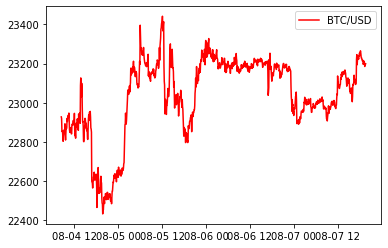

In [3]:
from datetime import datetime
from datetime import timedelta
exchange = ccxt.binanceus()

def get_data(start_date = None, timeframe = '5m'):
    data = exchange.fetch_ohlcv('BTC/USD', timeframe, limit=1000, since=start_date)
    df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    return df
df = get_data()
plt.plot(df['datetime'], df['close'], color = 'red')
plt.legend(['BTC/USD'])

# Fetch data since 1/1/2020 

def convert_date(x): return datetime.strptime(x, '%Y-%m-%d')


n = convert_date('2020-01-01')
n = int(n.timestamp()) * 1000
df = get_data(start_date=n)

df


In [4]:
df = get_data()
MACD = ta.macd(df['close'], n_fast=12, n_slow=26, n_sign=9)
MACD

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
995,7.857549,-7.897311,15.754860
996,5.017072,-8.590230,13.607302
997,3.605564,-8.001391,11.606955
998,2.388393,-7.374850,9.763242


In [5]:
df = get_data()
ta.stochrsi(df['close'], n=14)

,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
995,17.606790,14.907125
996,10.976724,15.392455
997,11.119184,13.234232
998,17.107383,13.067763


In [6]:
df = get_data()
bollinger = ta.bbands(df['close'], n=20, k=2)
bollinger

,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,22818.196362,22883.832,22949.467638,0.573642,0.295294
...,...,...,...,...,...
995,23192.987785,23204.164,23215.340215,0.096329,0.431372
996,23183.245084,23201.946,23220.646916,0.161201,0.042643
997,23181.413680,23200.772,23220.130320,0.166877,0.370547
998,23180.135212,23197.964,23215.792788,0.153710,0.413511


Text(0.5, 1.0, 'STOCHRSI')

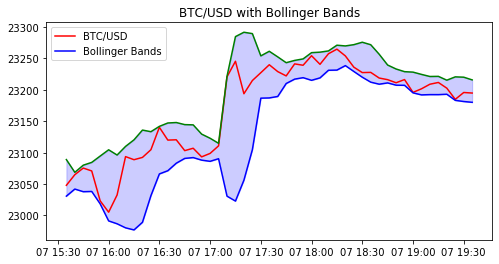

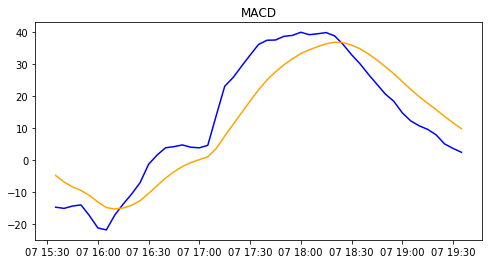

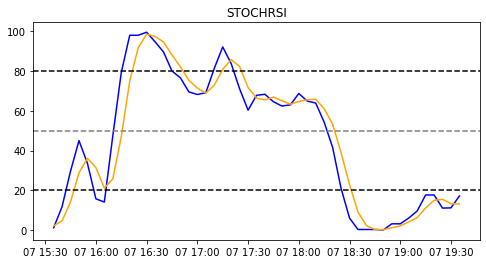

In [7]:
df = get_data()
MACD = ta.macd(df['close'], n_fast=12, n_slow=26, n_sign=9)
stochrsi = ta.stochrsi(df['close'], n=14)
bollinger = ta.bbands(df['close'], n=20, k=2)

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1], df['close'].iloc[-50:-1], color='red')
plt.plot(df['datetime'].iloc[-50:-1],
         bollinger['BBL_5_2.0'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         bollinger['BBU_5_2.0'].iloc[-50:-1], color='green')
plt.fill_between(df['datetime'].iloc[-50:-1], bollinger['BBL_5_2.0'].iloc[-50:-1], bollinger['BBU_5_2.0'].iloc[-50:-1], color='blue', alpha=0.2)
plt.legend(['BTC/USD', 'Bollinger Bands'])
plt.title('BTC/USD with Bollinger Bands')

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1], MACD['MACD_12_26_9'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1], MACD['MACDs_12_26_9'].iloc[-50:-1], color='orange')
plt.title('MACD')

plt.figure(figsize=(8, 4))
plt.plot(df['datetime'].iloc[-50:-1],
         stochrsi['STOCHRSIk_14_14_3_3'].iloc[-50:-1], color='blue')
plt.plot(df['datetime'].iloc[-50:-1],
         stochrsi['STOCHRSId_14_14_3_3'].iloc[-50:-1], color='orange')
plt.axhline(y=50, color='gray', linestyle='--')
plt.axhline(y=80, color='black', linestyle='--')
plt.axhline(y=20, color='black', linestyle='--')
plt.title('STOCHRSI')


# Ordering Algorithms

The strategy that will be implemented will be MACD focused with the confirmation from the STOCHRSI.  
<br>
If the difference of the MACD is positive, the strategy will be to buy the stock if the STOCHRSI is above the 50% level, indicating a strong trend. This will trigger an OCO order.
<br>
The stop loss will be set to -0.2% of the current price. and the Take-Profit will be 0.5% of the current price
<br>

# ML Integration
- Predict how much higher percentage the stock will be in 30 minutes.
    - Uses a Random Forest Classifier to predict the percentage increases.
    - Uses MACD, STOCHRSI, Volume, Bollinger Bands, and Close Price as features for linear regression to predict the next 30 minutes.


In [8]:
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
df['Next-Close'] = df['close'].shift(-6) # shift(-6) is 30 minutes in the future
df.dropna(inplace=True)

df

,date,open,high,low,close,volume,datetime,MACD,STOCHRSIk,STOCHRSId,BandWidth,Next-Close
33,1659611400000,22872.64,22875.31,22824.30,22841.04,12.608431,2022-08-04 11:10:00,-12.498883,1.460610e+01,15.903807,0.196175,22908.74
34,1659611700000,22838.94,22852.45,22814.50,22842.19,14.006215,2022-08-04 11:15:00,-12.152935,1.032619e+01,15.216714,0.228388,22909.27
35,1659612000000,22841.04,22897.07,22805.57,22888.59,13.864739,2022-08-04 11:20:00,-8.454270,1.773565e+01,14.222644,0.321078,22888.76
36,1659612300000,22889.36,22905.91,22874.67,22888.03,10.985745,2022-08-04 11:25:00,-5.825684,3.480622e+01,20.956019,0.370888,22889.28
37,1659612600000,22887.46,22901.66,22877.57,22893.79,12.734042,2022-08-04 11:30:00,-3.588993,5.335677e+01,35.299548,0.417270,22946.02
...,...,...,...,...,...,...,...,...,...,...,...,...
989,1659898200000,23215.57,23218.04,23184.01,23211.27,17.016618,2022-08-07 18:50:00,-8.530239,9.570122e-14,0.140727,0.110999,23202.63
990,1659898500000,23212.44,23224.99,23202.50,23216.33,6.341718,2022-08-07 18:55:00,-8.621932,3.067669e+00,1.092920,0.093492,23184.84
991,1659898800000,23216.33,23224.20,23193.02,23195.93,7.697648,2022-08-07 19:00:00,-9.775045,3.067669e+00,2.045113,0.142133,23195.76
992,1659899100000,23194.10,23222.30,23172.83,23201.63,28.073125,2022-08-07 19:05:00,-9.845068,5.958336e+00,4.031225,0.140600,23194.88


In [9]:
# df = get_data()
# df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
#                      n_sign=9)['MACDh_12_26_9']
# df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
# df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
# df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']

# df



# # shift(-6) is 30 minutes in the future
# df['Next-Close'] = df['close'].shift(-6)
# df.dropna(inplace=True)
# features = df[['open', 'high', 'low', 'MACD', 'close','STOCHRSIk', 'STOCHRSId',
#                'BandWidth', 'volume']]
# labels = df['Next-Close']

# data = pd.concat([features, labels], axis=1)
# train_data = data.sample(frac=0.8, random_state=0)
# test_data = data.drop(train_data.index)
# train_features = train_data.drop('Next-Close', axis=1)
# train_labels = train_data['Next-Close']
# test_features = test_data.drop('Next-Close', axis=1)
# test_labels = test_data['Next-Close']
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=1, input_shape=[len(train_features.columns)])
# ])
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(train_features, train_labels, epochs=500,
#             validation_split=0.2, verbose=1)
# predictions = model.predict(test_features)

# model.save('btc_model.h5')
# # model = tf.keras.models.load_model('myModel.h5')


In [10]:
from sklearn.metrics import mean_squared_error
# import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# print(model.evaluate(test_features, test_labels))
# print('RMSE: ', np.sqrt(mean_squared_error(test_labels, predictions)))
# print('MAE: ', mean_absolute_error(test_labels, predictions))
# print('R2: ', r2_score(test_labels, predictions))


# Training and Testing
- Making four seperate algorithms for 5,10,20,30 minutes in the future
- Returns a dataframe with percentage increase and the time it was predicted.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def convert_date(x): return int(
    datetime.strptime(x, '%Y-%m-%d').timestamp()*1000)


def convert_date_with_time(x): return int(
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()*1000)


df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                     n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']

df['FIVE_CLOSE'] = df['close'].shift(-1)
df['TEN_CLOSE'] = df['close'].shift(-2)
df['TWENTY_CLOSE'] = df['close'].shift(-4)
SHIFT = -6
# shift(-6) is 30 minutes in the future
df['THIRTY_CLOSE'] = df['close'].shift(SHIFT)
df.dropna(inplace=True)
SPLIT_RATIO = 0.6

features = np.array(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
labels = np.array(((df['THIRTY_CLOSE']-df['close'])/df['close'])*100)

five_Labels = np.array(((df['FIVE_CLOSE']-df['close'])/df['close'])*100)
ten_Labels = np.array(((df['TEN_CLOSE']-df['close'])/df['close'])*100)
twenty_Labels = np.array(((df['TWENTY_CLOSE']-df['close'])/df['close'])*100)
thirty_Labels = np.array(((df['THIRTY_CLOSE']-df['close'])/df['close'])*100)

train_features = features[:int(SPLIT_RATIO*len(features))]
test_features = features[int(SPLIT_RATIO*len(features)):]

train_labels = labels[:int(SPLIT_RATIO*len(features))]
test_labels = labels[int(SPLIT_RATIO*len(features)):]
# Create different models for each label
five_train_labels = five_Labels[:int(SPLIT_RATIO*len(features))]
five_test_labels = five_Labels[int(SPLIT_RATIO*len(features)):]
ten_train_labels = ten_Labels[:int(SPLIT_RATIO*len(features))]
ten_test_labels = ten_Labels[int(SPLIT_RATIO*len(features)):]
twenty_train_labels = twenty_Labels[:int(SPLIT_RATIO*len(features))]
twenty_test_labels = twenty_Labels[int(SPLIT_RATIO*len(features)):]
thirty_train_labels = thirty_Labels[:int(SPLIT_RATIO*len(features))]
thirty_test_labels = thirty_Labels[int(SPLIT_RATIO*len(features)):]


# Create a model for each label
five_model = RandomForestRegressor(n_estimators=100, random_state=0)
ten_model = RandomForestRegressor(n_estimators=100, random_state=0)
twenty_model = RandomForestRegressor(n_estimators=100, random_state=0)
thirty_model = RandomForestRegressor(n_estimators=100, random_state=0)


# Train the models
five_model.fit(train_features, five_train_labels)
ten_model.fit(train_features, ten_train_labels)
twenty_model.fit(train_features, twenty_train_labels)
thirty_model.fit(train_features, thirty_train_labels)


# Test the models
five_predictions = five_model.predict(test_features)
ten_predictions = ten_model.predict(test_features)
twenty_predictions = twenty_model.predict(test_features)
thirty_predictions = thirty_model.predict(test_features)


In [12]:
joblib.dump(five_model, "./five_model.joblib", compress=3)
joblib.dump(ten_model, "./ten_model.joblib", compress =3)
joblib.dump(twenty_model, "./twenty_model.joblib", compress =3)
joblib.dump(thirty_model, "./thirty_model.joblib", compress =3)

['./thirty_model.joblib']

In [24]:
def get_accuracy(test_labels, predictions, name = None):
    print(f'{name} MSE: {mean_squared_error(test_labels, predictions)}')
    print(f'{name} MAE: {mean_absolute_error(test_labels, predictions)}')
    print(f'{name} R2: {r2_score(test_labels, predictions)}')
    print(f'{name} RMSE: {np.sqrt(mean_squared_error(test_labels, predictions))}')


names = ['Five', 'Ten', 'Twenty', 'Thirty']
predictions = [five_predictions, ten_predictions, twenty_predictions, thirty_predictions]

for i in range(len(predictions)):
    get_accuracy(test_labels,predictions[i], names[i])


Five MSE: 0.04910740673052978
Five MAE: 0.15190274818741112
Five R2: -0.12134423577615427
Five RMSE: 0.22160191048483716
Ten MSE: 0.05243910339716276
Ten MAE: 0.16301176646638327
Ten R2: -0.19742194179276806
Ten RMSE: 0.22899585890832777
Twenty MSE: 0.06255703104483715
Twenty MAE: 0.1803847673037717
Twenty R2: -0.4284599990043354
Twenty RMSE: 0.2501140360812186
Thirty MSE: 0.06960683676593604
Thirty MAE: 0.194498967794776
Thirty R2: -0.5894389538099729
Thirty RMSE: 0.2638310761944772


In [14]:
# Test loading the model
five_model = ten_model = twenty_model = thirty_model = None

In [26]:
def predict_next_close(df):
    df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                        n_sign=9)['MACDh_12_26_9']
    df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
    df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
    df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']
    df.dropna(inplace=True)
    df['FIVE_CLOSE'] = df['close'].shift(-1)
    df['TEN_CLOSE'] = df['close'].shift(-2)
    df['TWENTY_CLOSE'] = df['close'].shift(-4)
    df['THIRTY_CLOSE'] = df['close'].shift(-6)

    five_model = joblib.load("./models/five_model.joblib")
    ten_model = joblib.load("./models/ten_model.joblib")
    twenty_model = joblib.load("./models/twenty_model.joblib")
    thirty_model = joblib.load("./models/thirty_model.joblib")


    five_predictions = five_model.predict(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    ten_predictions = ten_model.predict(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    twenty_predictions = twenty_model.predict(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    thirty_predictions = thirty_model.predict(df[['MACD', 'STOCHRSIk', 'STOCHRSId', 'BandWidth']])
    df['5 Minutes'] = five_predictions
    df['10 Minutes'] = ten_predictions
    df['20 Minutes'] = twenty_predictions
    df['30 Minutes'] = thirty_predictions
    df['Average'] = (df['5 Minutes'] + df['10 Minutes'] + df['20 Minutes'] + df['30 Minutes'])/4
    return df


from datetime import datetime

convert_date = lambda x: datetime.strptime(x, '%Y-%m-%d')

n = convert_date('2020-01-01')
n = int(n.timestamp()) * 1000
df = get_data()
predictions = predict_next_close(df)
df.to_csv('predictions.csv')




In [16]:
df = get_data()
predict_next_close(df)
profit = (df['Average'].iloc[-1] * (df['close'].iloc[-1]/100)) + df['close'].iloc[-1]
stop_loss = min([df['5 Minutes'].iloc[-1],df['10 Minutes'].iloc[-1], df['20 Minutes'].iloc[-1], df['30 Minutes'].iloc[-1]])
stop_loss = stop_loss * (df['close'].iloc[-1]/100) + df['close'].iloc[-1]
print('Price: ', df['close'].iloc[-1])
print('Profit: ', profit)
print('Stop Loss: ', stop_loss)


Price:  23192.73
Profit:  23193.530602743023
Stop Loss:  23183.452400625752


In [17]:
# model_loss = model.evaluate(test_features, test_labels)
# print(model_loss)


In [18]:
predictions = model.predict(test_features)
pred_result = pd.DataFrame(predictions, columns=['Predictions'])
label_df = pd.DataFrame(test_labels)
label_df.index = pred_result.index
plt.plot(pred_result, color='red')
plt.plot(label_df, color='blue')
plt.title('Close enough')
plt.legend(['Predictions', 'Actual'])
plt.show()


NameError: name 'model' is not defined

In [ ]:
df = get_data()
df['MACD'] = ta.macd(df['close'], n_fast=12, n_slow=26,
                        n_sign=9)['MACDh_12_26_9']
df['STOCHRSIk'] = ta.stochrsi(df['close'], n=14)['STOCHRSIk_14_14_3_3']
df['STOCHRSId'] = ta.stochrsi(df['close'], n=14)['STOCHRSId_14_14_3_3']
df['BandWidth'] = ta.bbands(df['close'], n=20, k=2)['BBB_5_2.0']

data = pd.concat([df['MACD'], df['STOCHRSIk'], df['STOCHRSId'],
                    df['BandWidth'], df['close'], df['volume']], axis=1)
data.dropna(inplace=True)

new_prediction = model.predict(data)
pred_df = pd.DataFrame(new_prediction, columns=['Predictions'])
pred_df.index = df.index[33:]
data['Prediction'] = pred_df

data

,MACD,STOCHRSIk,STOCHRSId,BandWidth,close,volume,Prediction
33,3.624347,70.291844,61.208957,0.405920,22868.51,14.088083,22868.050781
34,3.471218,66.013515,66.478346,0.218788,22862.17,17.159442,22856.384766
35,2.450320,60.055910,65.453756,0.115093,22852.74,18.630021,22843.722656
36,1.725433,52.067122,59.378849,0.112839,22855.72,11.279478,22843.253906
37,3.398880,62.263667,58.128900,0.250103,22892.84,33.902085,22889.638672
...,...,...,...,...,...,...,...
495,4.797340,87.231881,60.400145,0.823039,22589.75,28.453874,22603.166016
496,12.614897,100.000000,80.376810,1.211726,22669.80,54.806429,22679.845703
497,14.043411,93.631040,93.620974,0.856320,22616.80,30.129605,22612.814453
498,9.751662,79.397543,91.009527,0.770576,22538.59,26.080474,22527.332031


In [ ]:
data['close'].iloc[-1], data['Prediction'].iloc[-1]

(22549.32, 22533.732)